In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML

import os
import itertools
import gc
import pickle
import random

import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns

from zillow import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Training & Testing w/ XGBoost

In [2]:
zdata = DataLoader()
xgb = XGB(zdata)
gc.collect()

0

In [3]:
_ = xgb.train(verbose_eval=200)

[0]	train-mae:0.490147	valid-mae:0.487115
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[200]	train-mae:0.186491	valid-mae:0.189464
[400]	train-mae:0.087231	valid-mae:0.093491
[600]	train-mae:0.061051	valid-mae:0.069508
[800]	train-mae:0.05588	valid-mae:0.065579
[1000]	train-mae:0.054878	valid-mae:0.065151
[1200]	train-mae:0.054634	valid-mae:0.065123
Stopping. Best iteration:
[1115]	train-mae:0.054705	valid-mae:0.065121

[1115]	train-mae:0.054705	valid-mae:0.065121


# Baseline MAE = 0.065121

In [5]:
def filter_columns(missing):
    vals = describe_values(zdata.properties())
    return set(vals.loc[vals['missing %'] > missing]['column'])
cols_high_missing = filter_columns(missing=90)
cols_high_missing

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


{'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplaceflag',
 'hashottuborspa',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [6]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 3,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.2,
    'min_child_weight': 4,
    'lambda': 2,
}

_ = xgb.train(params=params, verbose_eval=200, dropcols=cols_high_missing)

[0]	train-mae:0.490149	valid-mae:0.487114
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[200]	train-mae:0.186549	valid-mae:0.189346
[400]	train-mae:0.087376	valid-mae:0.09376
[600]	train-mae:0.061226	valid-mae:0.069789
[800]	train-mae:0.056029	valid-mae:0.065758
[1000]	train-mae:0.055017	valid-mae:0.065251
[1200]	train-mae:0.054765	valid-mae:0.065189
[1400]	train-mae:0.054662	valid-mae:0.065174
[1600]	train-mae:0.054604	valid-mae:0.065164
[1800]	train-mae:0.054559	valid-mae:0.065158
[2000]	train-mae:0.054518	valid-mae:0.065146
Stopping. Best iteration:
[1951]	train-mae:0.054527	valid-mae:0.065146

[1951]	train-mae:0.054527	valid-mae:0.065146


# 0.065144

In [7]:
def recursive_feature_selection(cols, dropcols=None, reverse=False):
    if dropcols == None:
        dropcols = from_pickle('zillow/dropcols.pkl')
    if dropcols == None:
        dropcols = set()
    if cols is None:
        cols = set(zdata.preprocessed.properties().columns)
    cols = cols - dropcols
    clf, _ = xgb.train(dropcols=dropcols)
    mae = float(clf.attr('best_score'))
    mae_best = mae
    mae_best_pass = mae
    dropc = None

    i = 0
    while True:
        i += 1
        print ('Pass: ', i)
        for c in cols:
            print ('Evaluating: ', c)
            if reverse:
                clf, _ = xgb.train(dropcols=dropcols - set([c]))
            else:
                clf, _ = xgb.train(dropcols=dropcols | set([c]))
            mae = float(clf.attr('best_score'))
            if mae < mae_best_pass:
                mae_best_pass = mae
                dropc = c
            print ('Best MAE: {} - {}'.format(dropc, mae_best_pass))
        if mae_best_pass >= mae_best:
            print ('No more improvements')
            break
        else:
            print ('Dropping: ', dropc)
            print ('Best MAE: ', mae_best_pass)
            if reverse:
                cols.add(dropc)
                dropcols.remove(dropc)
            else:
                cols.remove(dropc)
                dropcols.add(dropc)
            to_pickle(dropcols, 'zillow/dropcols.pkl')
            mae_best = mae_best_pass
    print (dropcols)    

In [ ]:
cols = set(zdata.preprocessed.properties().columns)
recursive_feature_selection(cols, set(['parcelid', 'propertyzoningdesc', 
                                       'propertycountylandusecode', 'censustractandblock', 
                                       'rawcensustractandblock']))

[1115]	train-mae:0.054705	valid-mae:0.065121
Pass:  1
Evaluating:  structuretaxvaluedollarcnt
[1334]	train-mae:0.054561	valid-mae:0.06511
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  fips
[1439]	train-mae:0.054526	valid-mae:0.065113
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  lat_adj
[1439]	train-mae:0.054525	valid-mae:0.065114
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  taxdelinquencyyear
[1283]	train-mae:0.054586	valid-mae:0.065119
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  roomcnt
[1484]	train-mae:0.05451	valid-mae:0.065116
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  typeconstructiontypeid
[1483]	train-mae:0.05451	valid-mae:0.065115
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  buildingqualitytypeid
[1333]	train-mae:0.054563	valid-mae:0.065114
Best MAE: structuretaxvaluedollarcnt - 0.06511
Evaluating:  garagecarcnt
[1439]	train-mae:0.054524	valid-mae:0.065111
Best MAE: structuretaxvaluedoll

In [37]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 3,
    'silent': 1,
    'subsample': 0.32,
    'colsample_bytree': 0.1,
    'min_child_weight': 4,
    'lambda': 2,
}

dropcols = ['fips', 'tractandblock', 'roomcnt', 'bedroomcnt', 'taxdelinquencyyear', 'taxdelinquencyflag',
            'lon_adj_fips', 'lat_adj_fips', 'distance_fips']
_ = xgb.train(params=params, dropcols=dropcols)

[2772]	train-mae:0.05454	valid-mae:0.065142


## Best MAE = 0.06569021621458694

In [24]:
from zillow import DataLoader
import gc

zillow_data = DataLoader()
gc.collect()
mrg = zillow_data.preprocessed.training()

In [15]:
cols = [c for c in mrg.columns if c.startswith('logerror')] + ['transaction_month', 'fips', 'parcelid']
describe_values(mrg.loc[:, cols])

,column,dtype,sample,unique len,missing %
20,logerror,float64,"[-4.605, -4.51, -3.194]",1894,0.0
19,logerror_abs,float64,"[0.0, 0.001, 0.002]",1821,0.0
18,logerror_fips_month_ave,float64,"[0.00742772188285, 0.00773489987239, 0.0080547...",36,0.0
17,logerror_abs_fips_month_ave,float64,"[0.0492815758637, 0.0500673080075, 0.050865567...",36,0.0
16,logerror_fips_month_med,float64,"[0.00410710232063, 0.00425876132159, 0.0044160...",36,0.0
15,logerror_abs_fips_month_med,float64,"[0.0243297577389, 0.024628251523, 0.0249304074...",36,0.0
14,logerror_fips_month_std,float64,"[0.13466805267, 0.134760329299, 0.135065250867]",36,0.0
13,logerror_abs_fips_month_std,float64,"[0.120873461108, 0.122703834977, 0.125268871931]",36,0.0
12,logerror_fips_month_var,float64,"[0.0177779323931, 0.0183197126293, 0.018436485...",36,0.0
11,logerror_abs_fips_month_var,float64,"[0.0144280642187, 0.0147720403919, 0.015540429...",36,0.0


In [84]:
txns = zillow_data.preprocessed.transactions()
logerror_month = txns.groupby(['transaction_month']).std().reset_index().drop('parcelid', axis=1)
txns['logerror'].mean()

0.011457219606757128

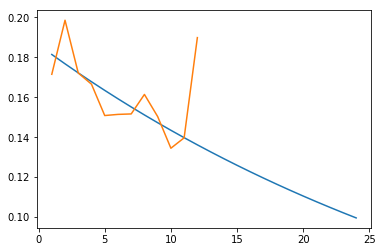

In [49]:
def plot_stat(trend, actual, stat):
    plt.plot(trend['transaction_month'], trend[stat])
    plt.plot(actual['transaction_month'], actual[stat])

trend = zillow_data.preprocessed.error_trend().groupby('transaction_month').mean().reset_index()
actual = zillow_data.preprocessed.error_month
plot_stat(trend, actual, 'logerror_month_std')

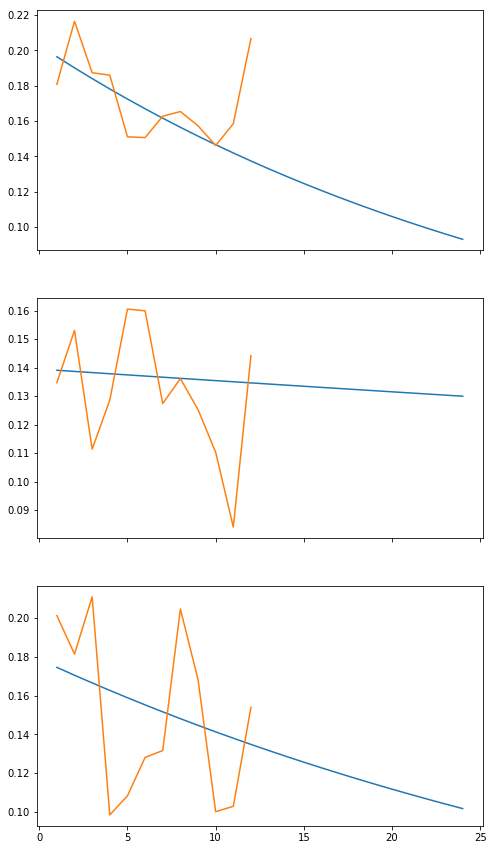

In [61]:
def plot_stat(trend, actual, stat, ax):
    ax.plot(trend['transaction_month'], trend[stat])
    ax.plot(actual['transaction_month'], actual[stat])

actual = zillow_data.preprocessed.error_fips_month
trend = zillow_data.preprocessed.error_trend()
ff, axes = plt.subplots(len(actual['fips'].unique()), sharex=True, figsize=(8,15))
for f, ax in zip(actual['fips'].unique(), axes):
    actual_fips = actual[actual['fips'] == f]
    trend_fips = trend[trend['fips'] == f]
    plot_stat(trend_fips, actual_fips, 'logerror_fips_month_std', ax)

0.17180730467250735

0.14327251133993027

0.13989326523193055

0.15865108328460498

0.13352731483737715

0.10840354639014932

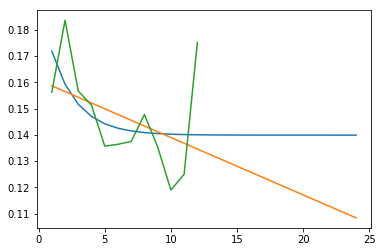

In [85]:
def plot(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*np.exp(-l*x)+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))

def plot_linear(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*x+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))
    
col = 'logerror_abs'
l = 0.5
coefs = np.polyfit(np.exp(-l*logerror_month['transaction_month']), logerror_month[col], 1)
plot(coefs)
coefs = np.polyfit(logerror_month['transaction_month'], logerror_month[col], 1)
plot_linear(coefs)
plt.plot(logerror_month['transaction_month'], logerror_month[col])

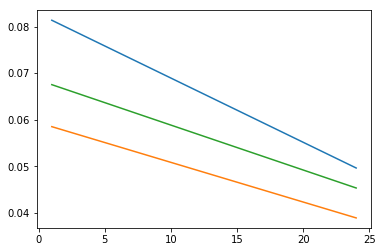

In [27]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_ave'])

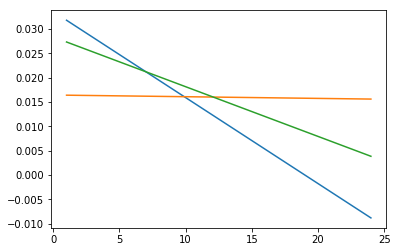

In [28]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_std'])

In [134]:
from zillow import *

In [10]:
zillow_data = DataLoader()
gc.collect()

349

In [92]:
def clr(epoch, lr_min=0.0001, lr_max=0.001, cycle=10):
    f = abs((epoch % cycle) - (cycle/2)) * 2 / cycle
    lr = lr_max - (lr_max - lr_min) * (1 - f)
    return lr

# for i in range(100):
#     print (clr(i))

clrs = keras.callbacks.LearningRateScheduler(clr)
mc = keras.callbacks.ModelCheckpoint('zillow/best_checkpoint.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = keras.callbacks.EarlyStopping(patience=20)
rlr = keras.callbacks.ReduceLROnPlateau(patience=1)

dropcols = set([
    'propertyzoningdesc', 
#    'propertycountylandusecode', 
    'censustractandblock', 
    'rawcensustractandblock',
#    'fips',
    'tractandblock',
    'roomcnt', 
    'bedroomcnt', 
    'taxdelinquencyflag',
    'taxdelinquencyyear',
])

nn = NeuralNet(zillow_data.preprocessed, dropcols=dropcols)
gc.collect()

334

In [93]:
nn.train(epochs=100, callbacks=[clrs, mc, es], verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

Train on 72158 samples, validate on 18117 samples
Epoch 1/100
 3584/72158 [>.............................] - ETA: 56s - loss: 0.1974

KeyboardInterrupt: 

In [80]:
nn.get_model().save_weights('zillow/0.065878423055811319.wgt')

In [94]:
nn.model = keras.models.load_model('zillow/best_checkpoint.wgt')
nn.test()

OSError: Unable to open file (Unable to open file: name = 'zillow/best_checkpoint.wgt', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [95]:
nn.model = keras.models.load_model('zillow/0.06564.model')
nn.model.summary()
nn.test()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

0.065641815279478044

In [96]:
nn.predict()

Predicting... 201610
2985217/2985217 [==============================] - 1748s  


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.001329,-0.000543,0.000269,0.008086,0.008881,0.009745
1,10759547,-0.001574,-0.000820,-0.000006,0.008022,0.008818,0.009724
2,10843547,0.134220,0.133590,0.132912,0.125679,0.125206,0.124847
3,10859147,0.018415,0.018959,0.019369,0.023672,0.024511,0.025387
4,10879947,-0.051201,-0.050091,-0.048864,-0.034099,-0.032662,-0.031290
5,10898347,0.007533,0.008366,0.009145,0.017660,0.018737,0.019805
6,10933547,-0.001705,-0.000885,0.000024,0.009310,0.010286,0.011317
7,10940747,0.012630,0.013250,0.013843,0.020965,0.022000,0.022968
8,10954547,-0.002739,-0.002030,-0.001167,0.008384,0.009353,0.010333
9,10976347,0.012277,0.012595,0.012783,0.017663,0.018473,0.019373


# EDA

## Training, Properties and Submission Data

In [ ]:
dv = describe_values(dl.get_properties())

In [ ]:
dv[dv['missing %'] < 50]

In [ ]:
tx = 'transactiondate'
train = dl.get_training()
train = split_date(train, tx).drop(tx, axis=1)
train = train.pivot_table(columns='parcelid', index=['transactiondate_year', 'transactiondate_month'], values='logerror')
display(train)

In [ ]:
# how much data is missing?
display(train.isnull().sum().sum() / (train.shape[0]*train.shape[1]))

Most parcels have only 1 data point. Too much missing data to be useful on a per parcel basis.

In [ ]:
prop_parcels = set(dl.get_properties()['parcelid'])
subm_parcels = set(dl.get_submission()['ParcelId'])
trxn_parcels = set(dl.get_training()['parcelid'])
prp = dl.get_properties()
nodt_parcels = set(prp.loc[prp.rawcensustractandblock.isnull(), 'parcelid'])

# Are all properties required in the submission?
display(len(prop_parcels - subm_parcels) == 0)

# Do all properties have recorded transactions?
display(len(prop_parcels - trxn_parcels) == 0)

# How much of the submission is missing?
display(len(subm_parcels - trxn_parcels))

print(len(nodt_parcels & trxn_parcels), 'parcels have no data but have transactions')

Also some parcels have no property data!

## Logerror

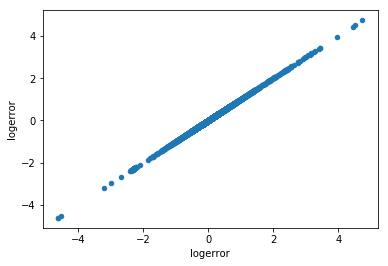

In [8]:
# check for outliers
pd.DataFrame(dl.get_training_preprocessed()['logerror']).plot.scatter(x='logerror', y='logerror')

In [ ]:
summarize(pd.DataFrame(dl.get_training()['logerror']))

In [13]:
# see if logerror varies per month

txm = 'transaction_month'
df = dl.get_training_preprocessed()

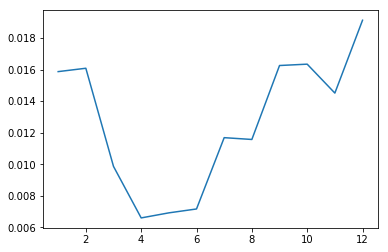

In [14]:
monthly = df[[txm, 'logerror']].groupby([txm])['logerror'].mean()
plt.plot(monthly.index, monthly)

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
plt.ylim(0.06, 0.08)
plt.plot(monthly.index, monthly)

In [ ]:
def plot_monthly(df, grp, val):
    monthly = df.groupby([grp, txm])[val].mean()
    figs = len(monthly.index.levels[0])
    f, axes = plt.subplots(figs, 1, figsize=(8, figs*4), sharex=True, sharey=True)
    for g, ax in zip(monthly.index.levels[0], axes):
        plt.subplot(ax)
        plt.plot(monthly[g].index, monthly[g])

In [ ]:
plot_monthly(df, 'fips', 'logerror')

In [ ]:
plot_monthly(df, 'fips', 'abs_logerror')

In [ ]:
plot_monthly(df, 'regionidcounty', 'abs_logerror')

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
monthly = monthly.reset_index()

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(monthly.drop('abs_logerror', axis=1), monthly['abs_logerror'])
preds = pd.DataFrame([ i for i in range(24)])
preds['abs_logerror'] = reg.predict(preds)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['abs_logerror'])
plt.plot(preds.index, preds['abs_logerror'])

In [ ]:
sns.lmplot(x=txm, y="abs_logerror", data=monthly, ci=None, palette="muted")

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha = .5)

def regress(df, val):
    monthly = df.groupby(['fips', 'age'])[val].mean()
    preds = pd.DataFrame()
    for f in monthly.index.levels[0]:
        fip = monthly[f].reset_index()
        lm.fit(fip.drop(val, axis=1), fip[val])
        next_months = pd.DataFrame([ i for i in range(13, 25)], columns=['age'])
        next_months[val] = lm.predict(next_months)
        next_months['fips'] = f
#         display(next_months)
        preds = preds.append(next_months)
    preds = preds.append(monthly.reset_index())
    display(preds)

regress(df, 'abs_logerror')